# (Forecasting Crop Yields on a national scale) FACYnation

### by Raphael Shirley (University of Sussex)

In this project we are using 30 years of crop yield data from various countries along with month resolution temperature and precipitation measurements to investigate a probabilistic model for predicting yields given the previous year's temperature and precipitation history.

## Step 1. Exploration of data and implementation of Bayesian version of current model

In the first notebook [Exploratory_analysis.ipynb](Exploratory_analysis.ipynb) Peter Hurley (DataJavelin) investigated the data that we have and how it can be manipulated using standard Python packages.

In the second notebook [Bayesian_MSM.ipynb](Bayesian_MSM.ipynb) Peter went on to implement a Bayesian inference version of the original model written by Ed Pope. This was done for only one of temperature and precipitation.

The original model assumes that there is some yield response function such that the total yield anomaly in year $j$ is $\Delta Y_j$, where the yield anomaly is the difference between year $j$ yield and the five year median $\widetilde{Y}_j(Y_{j-2},Y_{j-1},Y_{j},Y_{j+1},Y_{j+2} )$.

We then assume that this yield anomaly is related to a per month yield response function, $\dot{y}_i$, for each month $i$ by summation:

$$
\Delta Y_j = \sum_{i=1}^{12} \dot{y}_i
$$

Where the yield response function is some function of the monthly temperature anomaly $\Delta T_i$ and precipitation anomaly $\Delta P_i$ where both of which are the difference of the month $i$ measurement to the 30 year mean for that month. 

$$
\begin{align}
\dot{y}_i &= f(T_i, P_i) \\
& = s_t(\Delta T_i) + s_p(\Delta P_i)
\end{align}
$$

This assumes that the function is slowly changing on the scale of the temperature and precipitation anomalies such that a Taylor expansion to first order is sufficient. The previous notebook implemented this model for T only assuming that T and P are not correlated.






## Step 2. Implement Bayesian model to T and P simultaneously

Now lets implement the simple linear model but for temperature and precipitation simulataneously. We will begin with the same simple priors. The Liklihood will then be:

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

%matplotlib inline

In [9]:
maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_Indiana_temp_anom_real.csv')
maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
maize_precip=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_Indiana_precip_anom_real.csv')
maize_precip.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [23]:
# Compile model
sm=pystan.StanModel(file='BMSM-2d.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a0b17ba4c1397a6a38934128c82562d NOW.


In [24]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':1,
    'n_years':n_years,
    'd_temp':np.array(maize_temp.iloc[:,1:]).reshape(1,n_years,12),
    'd_precip':np.array(maize_precip.iloc[:,1:]).reshape(1,n_years,12),
    'd_yields':np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).astype(float).reshape(1,n_years)
}

In [25]:
fit=sm.sampling(data=data,chains=4,iter=1000,verbose=True)

In [26]:
fit

Inference for Stan model: anon_model_0a0b17ba4c1397a6a38934128c82562d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_temp[0,0]        -8.1e-4  3.8e-3   0.13  -0.26  -0.09 3.9e-3   0.09   0.24   1196    1.0
s_temp[0,1]         3.8e-3  2.8e-3   0.11  -0.21  -0.07 8.5e-3   0.08   0.21   1487    1.0
s_temp[0,2]          -0.08  2.7e-3   0.12  -0.31  -0.16  -0.08 2.0e-3   0.17   2000    1.0
s_temp[0,3]           0.06  4.0e-3   0.17  -0.28  -0.05   0.06   0.17   0.39   1732    1.0
s_temp[0,4]          -0.04  4.2e-3   0.16  -0.38  -0.15  -0.04   0.06   0.27   1442    1.0
s_temp[0,5]           0.04  7.7e-3   0.28  -0.52  -0.16   0.03   0.23   0.58   1354    1.0
s_temp[0,6]          -0.21  6.8e-3   0.23  -0.66  -0.36  -0.21  -0.05   0.24   1157    1.0
s_temp[0,7]          -0.23  5.2e-3   0.21  -0.64  -0.37  -0.23   -0.1   0.18   1561  

In [27]:
samples=fit.extract()

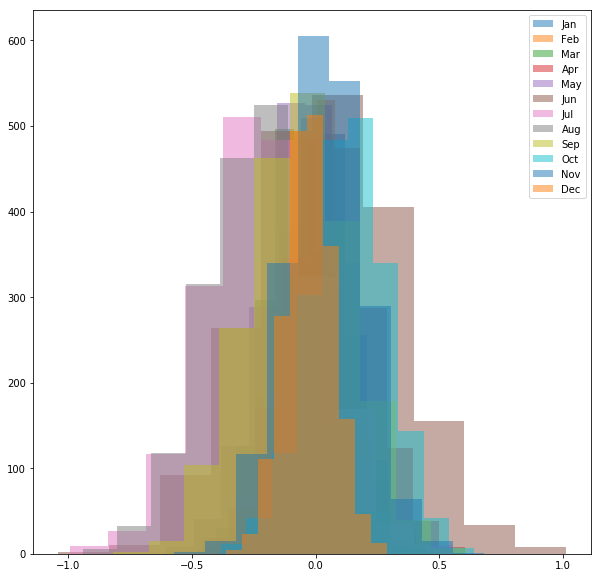

In [28]:
plt.figure(figsize=(10,10))
for i in range(0,12):
    plt.hist(samples['s_temp'][:,0,i], alpha=0.5,label=maize_temp.columns[1:][i])
plt.legend()

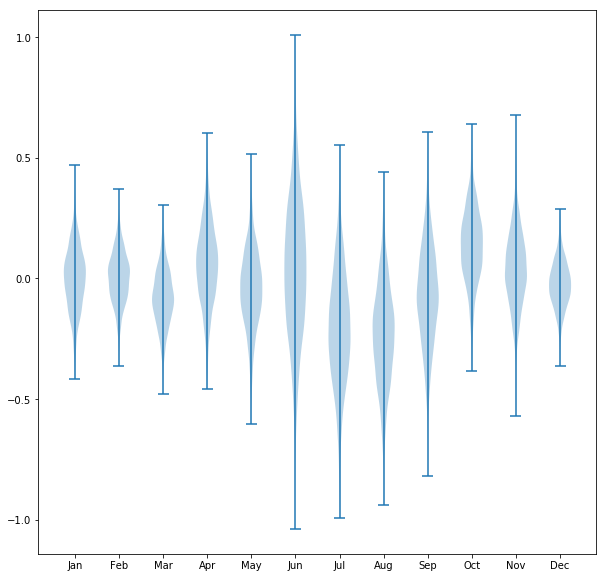

In [29]:
plt.figure(figsize=(10,10))
plt.violinplot(samples['s_temp'][:,0,:]);
plt.xticks(range(1,13),maize_temp.columns[1:]);

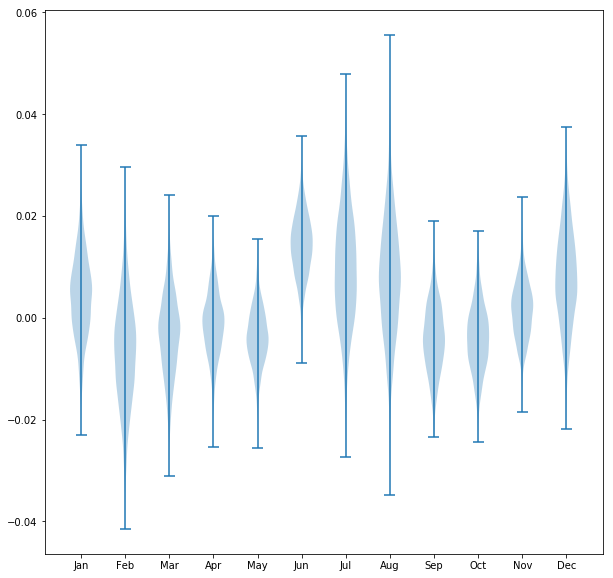

In [30]:
plt.figure(figsize=(10,10))
plt.violinplot(samples['s_precip'][:,0,:]);
plt.xticks(range(1,13),maize_temp.columns[1:]);

## Step 3. Implement Bayesian model to 2D Gausian of T and P 

We are assuming that for a given month there is some optimum temperature and pressure and that the yield response is some function with a broad peak. Lts try to implement a 2D Gaussian. Crucially our data for a given year does not well cover the T, P plane about the peak of the Gaussian